/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
400it [02:01,  3.40it/s]

[1,   400] loss: 0.1028985381


800it [03:59,  3.39it/s]

[1,   800] loss: 0.0521714683


938it [04:40,  3.35it/s]


Epoch 1/5, Loss: 0.20091208815574646


400it [01:58,  3.38it/s]

[2,   400] loss: 0.0368843361


800it [03:56,  3.38it/s]

[2,   800] loss: 0.0390617584


938it [04:37,  3.38it/s]


Epoch 2/5, Loss: 0.04540541023015976


400it [01:57,  3.41it/s]

[3,   400] loss: 0.0287231851


800it [03:55,  3.41it/s]

[3,   800] loss: 0.0303284768


938it [04:35,  3.40it/s]


Epoch 3/5, Loss: 0.1516696661710739


400it [01:57,  3.42it/s]

[4,   400] loss: 0.0268965702


800it [03:54,  3.42it/s]

[4,   800] loss: 0.0261949098


938it [04:34,  3.41it/s]


Epoch 4/5, Loss: 0.07422393560409546


400it [01:57,  3.42it/s]

[5,   400] loss: 0.0216455536


800it [03:54,  3.42it/s]

[5,   800] loss: 0.0196063370


938it [04:34,  3.42it/s]


Epoch 5/5, Loss: 0.00047794627607800066
Finished Training
Test Accuracy: 98.93%


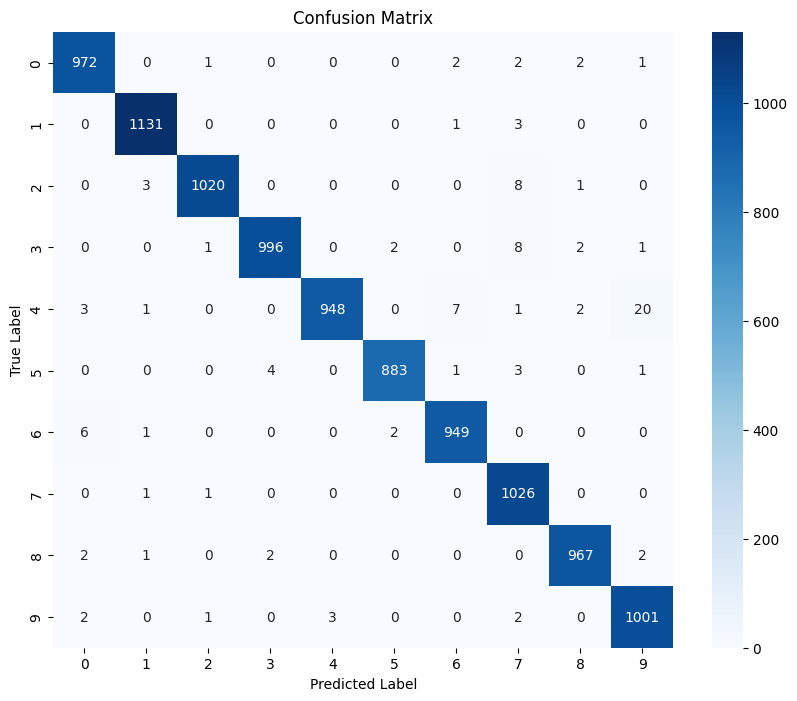

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Hyperparamters
BATCH = 64
num_epochs = 5
device = 'cuda'
SAVE_PATH = "./DenseNet_model.pt"
num_classes = 10

# Load data with transformations
data_transform = transforms.Compose([transforms.Resize((224, 224)),  # Resize to fit DenseNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert MNIST images to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=data_transform)
test_data = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=data_transform)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size= BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= BATCH, shuffle=False)

model = torchvision.models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)   
model = model.to(device)


## Train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 400 == 399:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.10f}')
            running_loss = 0.0

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Save model
torch.save(model.state_dict(), SAVE_PATH)

print('Finished Training')


correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
